# Notebook that does the processing of foraging session trajectories
'''Documentation about the task here'''

### Imports  
All functions are in behavior_analysis_functions.py

In [2]:
import os
import gc
import glob
import time
from processing_TowerCoordinates import *
from session_trajectory_processing import *




### Get mice data
Define the folder where your MOUXXX folder are, generate a list of MOUXXX folders and for each mice a list of sessions

In [3]:
# indicate where the data are
# path_to_data_folder is the path of the folder where you store your different mice.

# Windows:
# path_to_data_folder='C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
# Linux:
# path_to_data_folder '/home/david/Documents/Code/ForagingProject/Patchouris/patchouris/Sample_Data/'
# MacOs
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'


#path_to_data_folder='/home/david/Documents/David/Data/'
#path_to_data_folder='/LocalData/ForagingMice/JAK2Data'
#path_to_data_folder='/LocalData/ForagingMice/MaudData'

path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'


pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

# List all mice in the data folder (If you want to process all the mice in your data folder),
mice_list = [os.path.basename(path) for path in glob.glob(pattern_of_MOU_Folders)]
mice_list=sorted(mice_list)

# Print the number of mice, the list of mice, and add an empty line
print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder: {", ".join(mice_list)}\n')


#If you want to process a subset of mice uncomment the line below and comment the 2 lines above

#mice_list: list[str] = ["MOU2334"]  # For processing  a single mice. Equivalent to mice_list = ["MOU2334"] but more correct as it forces to create a list of string
#mice_list=['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']
#print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions:')
    print(session_list[mouse], '\n')








Found 8 mice in the data folder: MOU2329, MOU2330, MOU2331, MOU2332, MOU2333, MOU2334, MOU4087, MOU4175

Hello, I'm MOU2329! I have foraged for 22 sessions:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Hello, I'm MOU2330! I have foraged for 22 sessions:
['MOU2330_20240607-1335', 'MOU2330_20240607-1733', 'MOU2330_20240610-0956', 'MOU2330_20240610-1357', 'MOU2330_20240611-0936', 'MOU2330_20240611-1342', 'MOU2330_20240612-0937', 'MOU2330_20240612-1400', 'MOU2330_20240613-0933', 'MOU2330_202

## Process all the sessions of the mice in the mouse_list
### the key option here is wether to force processing or not (in case the data have already been processed)
#### for this the variable process should be set as true (to force) or false if the sessiobn has already been processed (if this is the case the name of the session has been saved in the  ListSessionsAnalyzed.txt file

In [31]:
mice_to_process = [mice_list[0]]
# Initialize the dictionary with empty lists for each mouse
mouse_trajectories = {mouse: [] for mouse in mice_to_process}

for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {session_to_process}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            print(session_data['average_speed'])

        runs_around_tower=session_data['all_epochs']['run_around_tower']
        positions=np.array(session_data['positions'])
        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch']==1:
                run_trajectory=positions[:,run_around_tower[0][0]:run_around_tower[0][1]]
                mouse_trajectories[mouse].append(run_trajectory)



        
        # Run the processing if file doesn't exist or overwrite is True
        

Processing mouse MOU2329. There is/are 22 sessions to process:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Getting the run trajectory of session MOU2329_20240607-1315
10.598492880986658
Getting the run trajectory of session MOU2329_20240607-1714
8.562056166582105
Getting the run trajectory of session MOU2329_20240610-0936
7.13728150681037
Getting the run trajectory of session MOU2329_20240610-1336
7.779379118575391
Getting the run trajectory of session MOU2329_20240611-0915
12.394838346

In [42]:
all_trajectories=mouse_trajectories[mouse]
length_all_trajectories=[]
for trajectory in all_trajectories:
    length_all_trajectories.append(trajectory.shape[1])

In [54]:
def plot_trajectories(trajectories):
    """
    Plot all trajectories on the same plot.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays of shape (2, X) representing the trajectories.
    """
    plt.figure(figsize=(8, 6))
    
    # Plot each trajectory
    for trajectory in trajectories:
        plt.plot(trajectory[0, :], trajectory[1, :], marker='o', linestyle='-', label='Trajectory')
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('All Trajectories')
    plt.grid(True)
    
    # Show the plot
    plt.show()

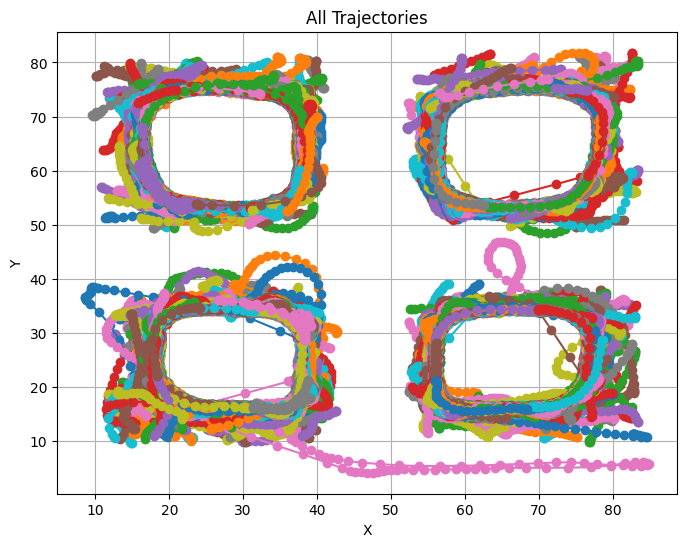

In [55]:
plot_trajectories(all_trajectories)

In [43]:
np.median(length_all_trajectories)

np.float64(20.0)

In [67]:
len(length_all_trajectories)

5379

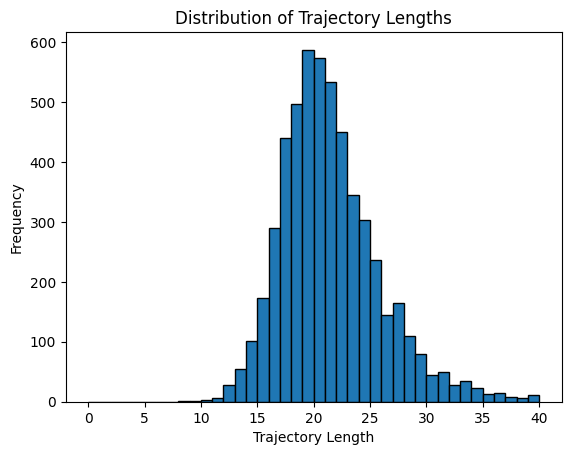

In [44]:
import matplotlib.pyplot as plt

# Define the bins from 0 to 40 in steps of 1
bins = range(0, 41, 1)

# Create the histogram plot
plt.hist(length_all_trajectories, bins=bins, edgecolor='black')

# Add labels and title
plt.xlabel('Trajectory Length')
plt.ylabel('Frequency')
plt.title('Distribution of Trajectory Lengths')

# Display the plot
plt.show()


In [45]:
def resample_trajectory(trajectory, target_size):
    """
    Resample a single trajectory to have the target number of points.
    
    Parameters:
        trajectory (np.ndarray): A 2D numpy array of shape (2, X).
        target_size (int): The target number of points (X).
        
    Returns:
        np.ndarray: A 2D numpy array of shape (2, target_size).
    """
    # Get current number of points
    current_size = trajectory.shape[1]
    
    # Create an array of indices for the original points and the target points
    original_indices = np.linspace(0, current_size - 1, num=current_size)
    target_indices = np.linspace(0, current_size - 1, num=target_size)
    
    # Resample by interpolating the trajectory for each row (x and y coordinates)
    resampled_trajectory = np.array([np.interp(target_indices, original_indices, trajectory[i, :])
                                     for i in range(2)])
    
    return resampled_trajectory

def resample_all_trajectories(all_trajectories, target_size):
    """
    Resample all trajectories to have the same target number of points.
    
    Parameters:
        all_trajectories (list): A list of 2D numpy arrays of shape (2, X).
        target_size (int): The target number of points for each trajectory.
        
    Returns:
        list: A list of resampled 2D numpy arrays of shape (2, target_size).
    """
    resampled_trajectories = [resample_trajectory(trajectory, target_size) for trajectory in all_trajectories]
    return resampled_trajectories


In [46]:
target_size = 20
resampled_trajectories = resample_all_trajectories(all_trajectories, target_size)


In [53]:
resampled_trajectories[400].shape

(2, 20)

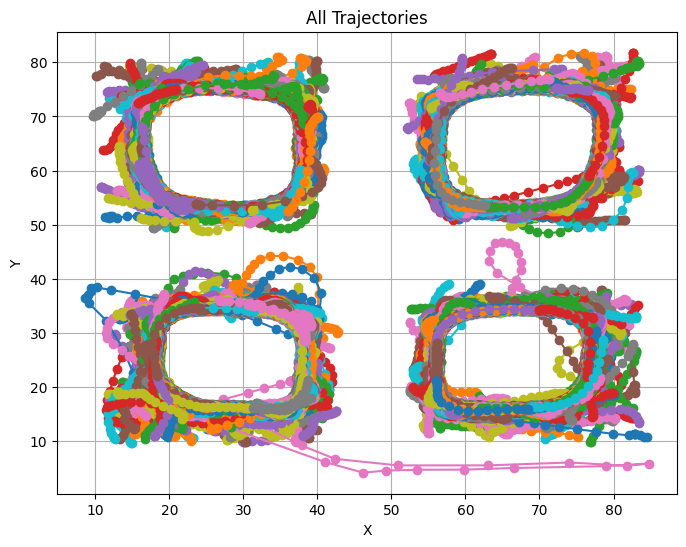

In [56]:
plot_trajectories(resampled_trajectories)


In [58]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_to_trajectory(trajectory, n_components=2):
    """
    Apply PCA to a single trajectory and return the first two principal components.
    
    Parameters:
        trajectory (np.ndarray): A 2D numpy array of shape (2, X).
        n_components (int): Number of principal components to keep.
        
    Returns:
        np.ndarray: A 2D numpy array of the transformed trajectory in the space of the first two PCs.
    """
    # Transpose trajectory to have shape (X, 2) for PCA input
    trajectory_t = trajectory.T
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    transformed_trajectory = pca.fit_transform(trajectory_t)
    
    return transformed_trajectory

def apply_pca_to_all_trajectories(trajectories, n_components=2):
    """
    Apply PCA to all trajectories and extract the first two principal components.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays of shape (2, X).
        n_components (int): Number of principal components to keep.
        
    Returns:
        list: A list of transformed trajectories in the space of the first two PCs.
    """
    transformed_trajectories = [apply_pca_to_trajectory(traj, n_components) for traj in trajectories]
    return transformed_trajectories


In [59]:
# Apply PCA to the resampled trajectories
pca_transformed_trajectories = apply_pca_to_all_trajectories(resampled_trajectories)

# Print the first two principal components of each trajectory
for idx, traj in enumerate(pca_transformed_trajectories):
    print(f"Trajectory {idx + 1} (first two PCs):\n{traj}\n")


Trajectory 1 (first two PCs):
[[ 3.38270624  0.04368058]
 [ 3.21886508  0.07301653]
 [ 3.0005559   0.08041845]
 [ 2.72458651  0.0641706 ]
 [ 2.38011659  0.01926225]
 [ 2.00964035 -0.0296291 ]
 [ 1.62355206 -0.06606057]
 [ 1.21022175 -0.08929197]
 [ 0.73443583 -0.09923036]
 [ 0.21360258 -0.10602601]
 [-0.30757266 -0.09662316]
 [-0.81452331 -0.06675014]
 [-1.27912172 -0.00810453]
 [-1.71172019  0.05452948]
 [-2.11253041  0.10477316]
 [-2.47501141  0.13237693]
 [-2.73893683  0.09928189]
 [-2.91591614  0.03571172]
 [-3.0340577  -0.03789195]
 [-3.10889251 -0.10761383]]

Trajectory 2 (first two PCs):
[[ 3.9788001  -0.54139447]
 [ 3.94303674 -0.48078052]
 [ 3.8680331  -0.36107481]
 [ 3.72802644 -0.18067949]
 [ 3.48001263  0.06936798]
 [ 2.89894557  0.34783708]
 [ 2.03710251  0.55993304]
 [ 0.97860049  0.67618378]
 [-0.09930395  0.62954044]
 [-0.88544275  0.47343775]
 [-1.49733903  0.30217572]
 [-1.96407506  0.13970067]
 [-2.31353909  0.01144422]
 [-2.57360699 -0.12051577]
 [-2.73951845 -0.234

In [62]:
pca_transformed_trajectories[0]

array([[ 3.38270624,  0.04368058],
       [ 3.21886508,  0.07301653],
       [ 3.0005559 ,  0.08041845],
       [ 2.72458651,  0.0641706 ],
       [ 2.38011659,  0.01926225],
       [ 2.00964035, -0.0296291 ],
       [ 1.62355206, -0.06606057],
       [ 1.21022175, -0.08929197],
       [ 0.73443583, -0.09923036],
       [ 0.21360258, -0.10602601],
       [-0.30757266, -0.09662316],
       [-0.81452331, -0.06675014],
       [-1.27912172, -0.00810453],
       [-1.71172019,  0.05452948],
       [-2.11253041,  0.10477316],
       [-2.47501141,  0.13237693],
       [-2.73893683,  0.09928189],
       [-2.91591614,  0.03571172],
       [-3.0340577 , -0.03789195],
       [-3.10889251, -0.10761383]])

In [63]:
def prepare_data_for_pca(trajectories):
    """
    Flatten each trajectory and combine them into a single dataset for PCA.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays where each array has shape (2, 20).
        
    Returns:
        np.ndarray: A 2D numpy array where each row represents a flattened trajectory.
    """
    # Flatten each trajectory and stack them into a single matrix
    flattened_trajectories = [traj.flatten() for traj in trajectories]
    combined_data = np.array(flattened_trajectories)
    return combined_data

In [64]:
combined_data=prepare_data_for_pca(resampled_trajectories)

In [75]:
import matplotlib.cm as cm
def apply_pca(combined_data, n_components=2):
    """
    Apply PCA to the combined dataset.
    
    Parameters:
        combined_data (np.ndarray): The dataset to apply PCA to.
        n_components (int): Number of principal components to keep.
        
    Returns:
        PCA: Fitted PCA object.
        np.ndarray: The transformed data in PCA space.
    """
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(combined_data)
    return pca, pca_transformed

def transform_trajectory(pca, trajectory):
    """
    Transform a single trajectory into the PCA space.
    
    Parameters:
        pca (PCA): Fitted PCA object.
        trajectory (np.ndarray): A 2D numpy array of shape (2, 20).
        
    Returns:
        np.ndarray: The transformed trajectory in PCA space.
    """
    trajectory_flattened = trajectory.flatten().reshape(1, -1)
    transformed_trajectory = pca.transform(trajectory_flattened)
    return transformed_trajectory

def plot_pca_trajectories(pca_transformed_trajectories):
    """
    Plot PCA-transformed trajectories as points in 2D space with a gradient color from first to last trajectory.
    
    Parameters:
        pca_transformed_trajectories (np.ndarray): A 2D numpy array where each row represents a trajectory in PCA space.
    """
    plt.figure(figsize=(8, 6))
    
    # Create a color map with a gradient
    num_trajectories = pca_transformed_trajectories.shape[0]
    colors = cm.viridis(np.linspace(0, 1, num_trajectories))
    
    # Plot each trajectory as a point with its corresponding color from the gradient
    for i, traj in enumerate(pca_transformed_trajectories):
        plt.scatter(traj[0], traj[1], color=colors[i], label=f'Trajectory {i+1}')
    
    # Add labels and title
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Transformed Trajectories with Gradient Coloring')
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [70]:
pca, pca_transformed=apply_pca(combined_data)

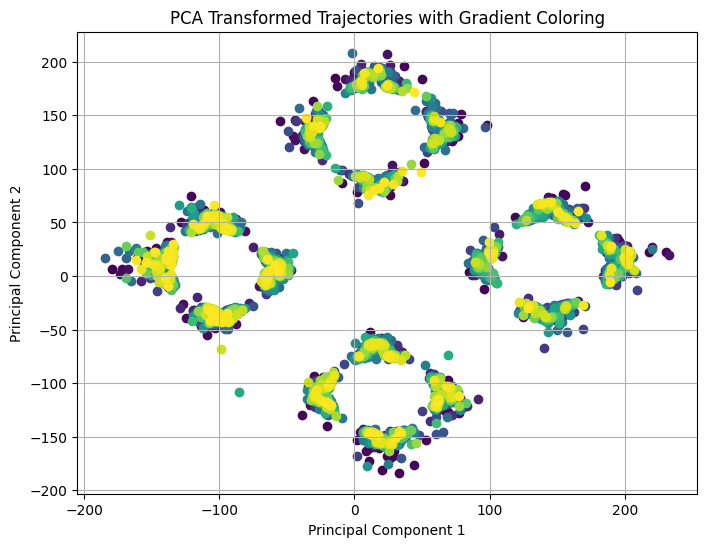

In [76]:
# Transform each trajectory to PCA space
pca_transformed_trajectories = np.array([transform_trajectory(pca, traj).flatten() for traj in resampled_trajectories])

# Plot the PCA-transformed trajectories
plot_pca_trajectories(pca_transformed_trajectories)

In [74]:
pca

PCA(n_components=2)

In [ ]:
# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

mice_to_process = [mice_list[0]]
for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Processing the trajectory of session {session_to_process}')
        if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
            trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
            all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
            
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not overwrite and os.path.exists(output_pickle_filepath):
            print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
            continue  # Skip processing if the file exists and overwrite is False
        
        # Run the processing if file doesn't exist or overwrite is True
        process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
        print('#########################\n')

Processing mouse MOU2329. There is/are 22 sessions to process:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Processing the trajectory of session MOU2329_20240607-1315
Total time: 885.00 s.
The total distance is: 93.80 m
The average running speed is: 10.60 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /Users/davidrobbe/Documents/Science/Data/Foragin

In [ ]:
# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

mice_to_process = [mice_list[0]]
for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Processing the trajectory of session {session_to_process}')
        if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
            trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
            all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
            
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not overwrite and os.path.exists(output_pickle_filepath):
            print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
            continue  # Skip processing if the file exists and overwrite is False
        
        # Run the processing if file doesn't exist or overwrite is True
        process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
        print('#########################\n')

Processing mouse MOU2329. There is/are 22 sessions to process:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Processing the trajectory of session MOU2329_20240607-1315
Total time: 885.00 s.
The total distance is: 93.80 m
The average running speed is: 10.60 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /Users/davidrobbe/Documents/Science/Data/Foragin

In [ ]:
# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

mice_to_process = [mice_list[0]]
for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Processing the trajectory of session {session_to_process}')
        if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
            trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
            all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
            
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not overwrite and os.path.exists(output_pickle_filepath):
            print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
            continue  # Skip processing if the file exists and overwrite is False
        
        # Run the processing if file doesn't exist or overwrite is True
        process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
        print('#########################\n')

Processing mouse MOU2329. There is/are 22 sessions to process:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Processing the trajectory of session MOU2329_20240607-1315
Total time: 885.00 s.
The total distance is: 93.80 m
The average running speed is: 10.60 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /Users/davidrobbe/Documents/Science/Data/Foragin

### Process a defined subset of sessions of a single mice in the mouse_list

In [9]:
# same of code as above if you want to process a single session for a single mouse (obviously yu can process two or three)
mice_to_process="MOU2333"
sessions_to_process=['MOU2333_20240610-1557', 'MOU2333_20240611-1118']

# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

folder_path_mouse_to_process = os.path.join(path_to_data_folder, mice_to_process)

# Get the list of sessions


nb_sessions = len(sessions_to_process)
print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
print(sessions_to_process, '\n')

# Process each session
for sessionindex,session_to_process in enumerate(sessions_to_process):
    print(f'Processing the trajectory of session {session_to_process}')
    if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
        trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
        all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
        
    
    # Define the pickle file path
    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
    
    # Check if the pickle file already exists
    if not overwrite and os.path.exists(output_pickle_filepath):
        print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
        continue  # Skip processing if the file exists and overwrite is False
    
    # Run the processing if file doesn't exist or overwrite is True
    process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
    print('#########################\n')

Processing mouse MOU2329. There is/are 2 sessions to process:
['MOU2333_20240610-1557', 'MOU2333_20240611-1118'] 

Processing the trajectory of session MOU2333_20240610-1557
Total time: 884.96 s.
The total distance is: 74.38 m
The average running speed is: 8.40 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /LocalData/ForagingMice/JAK2Data/MOU2333/MOU2333_20240610-1557/MOU2333_20240610-1557_basic_processing_output.pickle
#########################

Processing the trajectory of session MOU2333_20240611-1118
Total time: 885.00 s.
The total distance is: 78.86 m
The average running speed is: 8.91 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /LocalData/ForagingMice/JAK2Data/MOU2333/MOU2333_20240611-1118/MOU2333_2